<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative_inference19102021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project:** Posgraduate Business Intelligence Master PUC-RJ 2021

# **Classification and Prediction of rocks images in drilled wells via Learning Methods Supervised by deep learning and pre trained models**

This work will focus on the analysis of the application of supervised learning methods to the prediction of rock images in drilling wells and represents a new study to be developed by the technical team.

The use of deep learning for the budgeting process has a number of advantages, including the reduction of HH involved, improvement in the degree of assertiveness, speed of response and the possibility of testing different project scenarios in less time.

This work proposes to classify the rocks through their images acquired during geological activities (drilling), using a Deep Learning technique and pre-trained models. 

In [ ]:
# Import from libraries

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
from os import getcwd

import tensorflow as tf
import zipfile
import sys
import shutil
import numpy as np
import glob
import random
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
from keras.utils import np_utils
from PIL import Image
import plotly.express as px
import cv2 as cv
from imutils import paths
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split

In [ ]:
# Checking Tensorflow and Keras Versions
print(tf.__version__)

# Install Tensorflow
#!pip install tensorflow==2.6.0

# Install Keras
!pip install keras --upgrade

2.6.0


In [ ]:
# If necessary, remove the directories

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/
!rm -rf geological_similarity

In [ ]:
!umount -f /content/drive


# **2. Extraction, Transformation and Loading of the Data**

## **2.1. Kaglle Data Collection**

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.

#!kaggle datasets download fabiobasson/geologicalsimilarity
#! unzip -qq  geologicalsimilarity
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity   

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle/kaggle.': No such file or directory
 74% 25.0M/33.6M [00:00<00:00, 48.2MB/s]
100% 33.6M/33.6M [00:00<00:00, 62.2MB/s]


# **Creating the directory structure**

In [ ]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir= glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))

andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

label1=['andesite','gneiss','marble','quartzite','rhyolite','schist']

for i in andesite_dir:
    andesite_df.append([i,label1[0]])
for j in gneiss_dir:
   gneiss_df.append([j,label1[1]])
for l in marble_dir:
    marble_df.append([l,label1[2]])
for m in quartzite_dir:
    quartzite_df.append([m,label1[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,label1[4]])
for o in schist_dir:
    schist_df.append([o,label1[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)


5000
5000
4998
5000
5000
5000


29998

# **Creation of Parameters**

In [ ]:
INIT_LR = 1e-3
EPOCHS = 200
BS=24

# **Dataframe Creation**

In [ ]:
# Criação do Dataframe
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,geological_similarity/schist/FAGX6.jpg,schist
1,geological_similarity/schist/R5V7H.jpg,schist
2,geological_similarity/rhyolite/BEYN0.jpg,rhyolite
3,geological_similarity/andesite/DH2JR.jpg,andesite
4,geological_similarity/gneiss/Z5QTI.jpg,gneiss
...,...,...
29993,geological_similarity/quartzite/CZFNX.jpg,quartzite
29994,geological_similarity/gneiss/ODZAA.jpg,gneiss
29995,geological_similarity/andesite/9NSMZ.jpg,andesite
29996,geological_similarity/marble/1OCMU.jpg,marble


# **Convert the images to 32 by 32**

In [ ]:
dados=[]
labels=[]

for imagePath in data_df['path']:

      label = imagePath.split(os.path.sep)[-2]

      image = cv.imread(imagePath)
      image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      image = cv.resize(image, (32, 32))
      
      dados.append(image)
      labels.append(label)
      
print("labels: ", np.unique(labels))

# Convert data and labels to NumPy arrays while scaling the pixel
dados = np.array(dados) 
labels = np.array(labels)
labels

labels:  ['andesite' 'gneiss' 'marble' 'quartzite' 'rhyolite' 'schist']


array(['schist', 'schist', 'rhyolite', ..., 'andesite', 'marble',
       'quartzite'], dtype='<U9')

# **Renaming labels from string format to int**

In [ ]:
lb={'andesite':[1, 0, 0, 0, 0, 0] ,'gneiss':[0, 1, 0, 0, 0, 0] ,'marble':[0, 0, 1, 0, 0, 0], 'quartzite':[0, 0, 0, 1, 0, 0], 'rhyolite':[0, 0, 0, 0, 1, 0], 'schist':[0, 0, 0, 0, 0, 1]}
len(labels)

labels1 = [lb[label] for label in labels]
labels1 = np.array(labels1)
print(labels1)

[[0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 ...
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]]


# **Creating the Dataframe on Training, Validation and Testing Data**

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(dados, labels1, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train,test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(17998, 32, 32, 3)
(17998, 6)
(6000, 32, 32, 3)
(6000, 6)
(6000, 32, 32, 3)
(6000, 6)


# **Normalization**

In [ ]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

# **Escolha do modelo a ser aplicado**

# **Importante!**
Para realizar a inferência não faremos tratamento de missing values. As colunas que contém missing values serão descartadas. Por isso, o modelo selecionado deve conter todas as variáveis exigidas pelo modelo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#import os
#workdir_path = '/content/drive/My Drive'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
#os.chdir(workdir_path)

In [ ]:
opcao = str(input('Qual modelo será aplicado? (Modelo Criado, Modelo VGG16 ou Modelo C) ')).strip().upper()

Qual modelo será aplicado? (Modelo Criado, Modelo VGG16 ou Modelo C) Modelo Criado


In [ ]:
if opcao == 'MODELO CRIADO':
    model = tf.keras.models.load_model('/content/drive/My Drive/models/best_model.h5')
if opcao == 'MODELO VGG16':
    model = tf.keras.models.load_model('/content/drive/My Drive/models/modelvgg16')
print (opcao)

# **Performing predictions and confirmations**

In [ ]:
# (ref http://stackoverflow.com/q/32239577/395857)

def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
print("Conv2D - resultados")

#model = tf.keras.models.load_model("/content/drive/My Drive/models/best_model.h5")

y_pred = model.predict(X_test,batch_size=BS)
print("Prediction_accuracy: " + str(y_pred))

print("-------\n")

Conv2D - resultados
Prediction_accuracy: [[2.0520697e-06 4.8206355e-03 1.1405771e-06 8.5574047e-06 5.5042592e-06
  9.9516219e-01]
 [1.3863478e-09 9.9961299e-01 9.1871222e-10 3.9182094e-08 2.5977018e-13
  3.8703351e-04]
 [1.5971558e-04 7.1838317e-06 1.7395688e-08 9.9982160e-01 9.8581154e-07
  1.0616540e-05]
 ...
 [1.4283179e-08 8.0319267e-04 1.2902349e-08 3.6463447e-07 5.4824604e-08
  9.9919635e-01]
 [9.9456716e-01 3.0305691e-07 3.9564688e-07 5.3256210e-03 9.1640679e-05
  1.4847942e-05]
 [3.0562378e-06 7.4733151e-07 9.9999547e-01 1.4876826e-08 5.8529139e-07
  6.5864626e-08]]
-------



In [ ]:
y_pred[400] #  400 position prediction

array([1.2653174e-03, 5.0386800e-05, 2.1660077e-07, 9.9860018e-01,
       6.4938854e-06, 7.7368102e-05], dtype=float32)

In [ ]:
print(np.argmax(y_pred[400])) # In this case, the prediction is pointed out - Class 4

3


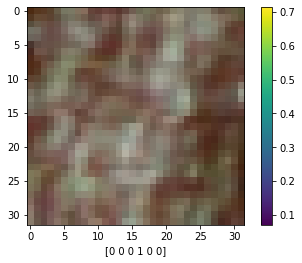

In [ ]:
# In this case, the prediction is correct - Class 4, as shown below:
plt.figure()
plt.imshow(X_train[400])
plt.xlabel(y_test[400])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
y_pred[105] # first prediction position 5

array([3.8940005e-03, 1.3569436e-07, 2.6354619e-06, 5.4960701e-06,
       9.9608105e-01, 1.6788328e-05], dtype=float32)

In [ ]:
np.argmax(y_pred[105]) # In this case, the prediction is correct - Class 05

4

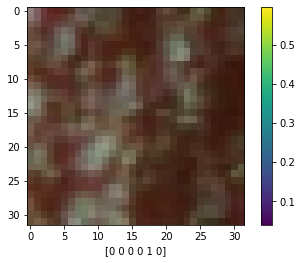

In [ ]:
# In this case, the prediction is correct - Class 05, as shown in the figure below:
plt.figure()
plt.imshow(X_train[105])
plt.xlabel(y_test[105])
plt.colorbar()
plt.grid(False)
plt.show()

# **Prediction for a single image**

In [ ]:
img = X_test [50]
test_labels_single = y_test [50]
print(img.shape)

test_labels_single

# Adiciona a imagem em um batch que possui um só membro.
img = (np.expand_dims(img,0))

print(img.shape)

(32, 32, 3)
(1, 32, 32, 3)


In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

predictions_single = np.argmax(predictions_single, axis=1)
predictions_single

[[2.1287185e-04 7.6271090e-06 8.6457547e-08 9.9976009e-01 3.9063539e-06
  1.5401147e-05]]


array([3])

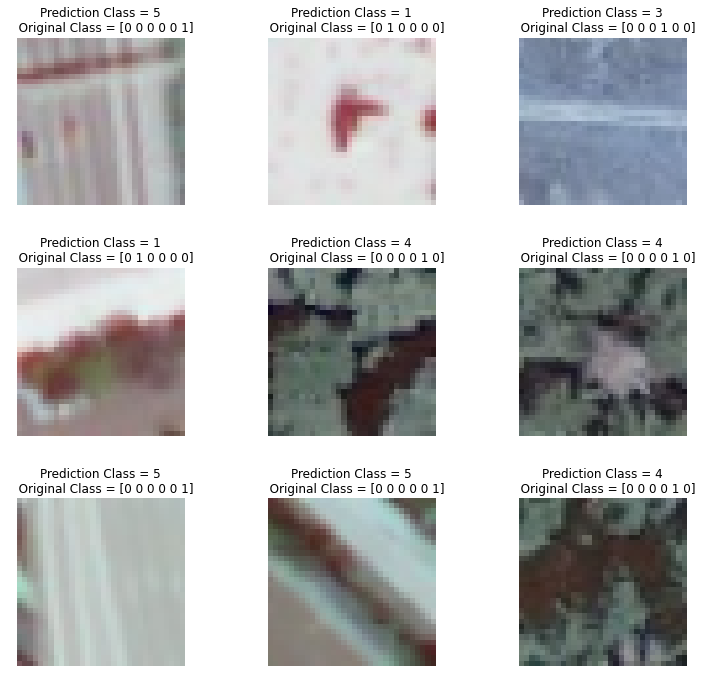

In [ ]:
#Get the predictions for the test data
predicted_classes = model.predict(X_test,batch_size=BS)
predicted_classes = np.argmax(predicted_classes, axis=1)

L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"Prediction Class = {predicted_classes[i]}\n   Original Class = {y_test[i]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)